## The main workshop challenge

This Notebook demonstrates some solutions for unsupervised fraud detection strategies. 

Labels are not used for tuning. 



In [1]:
# standard library imports
import os
import sys
from collections import Counter

# pandas, seaborn etc.
import seaborn as sns
import sklearn 
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

# sklearn outlier models
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN

# other sklearn functions
from sklearn.decomposition import PCA
from sklearn.covariance import MinCovDet, EmpiricalCovariance
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale as preproc_scale

# pyod
import pyod
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.knn import KNN   

sys.path.append("..") #to enable importing from ../outlierutils

Using TensorFlow backend.


In [43]:
import scipy
scipy.__version__

'1.3.2'

In [2]:
from outlierutils import plot_top_N, plot_outlier_scores, LabelSubmitter
%load_ext autoreload
%autoreload 2

In [3]:
## SETTINGS
only_hasid = True

In [4]:
data_path = '../data/'
x_fraud = pd.read_pickle(os.path.join(data_path, 'x_fraud.pkl'))
y_fraud = pd.read_pickle(os.path.join(data_path, 'y_fraud.pkl'))
print('Shape of the X-data: {}'.format(x_fraud.shape))
print('Mean of the y variable: {:.2%}'.format(y_fraud.mean()))

Shape of the X-data: (200000, 434)
Mean of the y variable: 3.01%


In [42]:
pd.read_pickle(os.path.join(data_path, 'y_pendigits.pkl'))

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
9863   NaN
9864   NaN
9865   NaN
9866   NaN
9867   NaN
Name: outlier, Length: 9868, dtype: float64

In [5]:
if only_hasid:
    idx_tokeep = x_fraud[x_fraud.has_id==1].index
    x_fraud = x_fraud.loc[idx_tokeep, :]
    y_fraud = y_fraud.loc[idx_tokeep]

# Drop columns with only NaN's
x_fraud = x_fraud.dropna(axis=1, how='all')
    
# Remove columns with only a single value
constant_cols = [xn for xn in x_fraud.columns if x_fraud[xn].nunique()==1] # looping to limit memory usage
x_fraud = x_fraud.drop(columns=constant_cols)
print('Columns with a single unique value: {}'.format(constant_cols))

Columns with a single unique value: ['C5', 'C9', 'V12', 'V13', 'V29', 'V30', 'V35', 'V36', 'V48', 'V49', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V90', 'V91', 'V107', 'V305', 'has_id']


In [6]:
print('Shape of the X-data: {}'.format(x_fraud.shape))
print('Mean of the y variable: {:.2%}'.format(y_fraud.mean()))

Shape of the X-data: (70093, 392)
Mean of the y variable: 4.88%


In [7]:
def label_encoding(df, columns=None):
    if columns is None:
        columns = df.columns
    for col in columns:
        le = LabelEncoder()
        le.fit(list(df[col].astype(str).values))
        df.loc[:, col] = le.transform(list(df.loc[:, col].astype(str).values))
    return df

def median_imputation(df, median_impute_limit=0.95, impute_val=-999):
    """ inf/nan Values that occur more often than median_impute_limit are imputed with the median
    when less often, they are imputed by impute_val. 
    Set median_impute_limit to 0 to always do median imputation
    """
    df = df.replace([np.inf, -np.inf], np.nan)
    for col in df.columns:
        if not df[col].dtype == 'object':
            mean_nan = df[col].isna().mean()
            if mean_nan > median_impute_limit: # then, impute by median
                df[col] = df[col].fillna(df[col].median())
            elif mean_nan > 0 and mean_nan <= median_impute_limit:
                df[col] = df[col].fillna(impute_val)
                
    return df

In [8]:
column_groups = {'card': [c for c in x_fraud.columns if c.startswith('card')],
                   'addr': [c for c in x_fraud.columns if c.startswith('addr')],
                   'dist1': ['dist2'],
                   'C' : [c for c in x_fraud.columns if c.startswith('C')],
                   'D' : [c for c in x_fraud.columns if c.lstrip('D').isnumeric()],
                   'M' : [c for c in x_fraud.columns if c.startswith('M')],
                   'id' : [c for c in x_fraud.columns if c.startswith('id')],   
                   'V': [c for c in x_fraud.columns if c.startswith('V')],
                   'trans': [c for c in x_fraud.columns if c.startswith('Trans')]}


### Card columns

These are supposedly categorical, but have many unique values. Leave numerical, except for card4 and card6 (that have only 4 unique values). Do a mode fill on the NaN columns

In [9]:
card_cols = pd.get_dummies(x_fraud[column_groups['card']], columns=['card4', 'card6'], drop_first=True)

In [10]:
card_cols = card_cols.fillna(card_cols.mode().iloc[0]) #NB: iloc: fillna needs a 1-D object to be applied on columns

In [11]:
# Check: No Nan's, no text
assert not card_cols.isna().sum().sum(), 'NaNs still present'
assert not [c for c in card_cols.dtypes if c==object]

In [12]:
card_colnames_dummies = [col for col in card_cols.columns if col.startswith('card4') or col.startswith('card6')]
card_colnames_numeric = [col for col in card_cols.columns if col not in card_colnames_dummies]

### Dist columns

These represent "distances between (not limited) billing address, mailing address, zip code, IP address, phone area, etc.”, thus are numeric

In [13]:
#dist_cols = pd.concat((x_fraud[['dist1']].fillna(x_fraud[['dist1']].median()), 
#                        x_fraud[['dist1']].isna().astype(int).rename(columns={'dist1': 'dist1_nan'}),
#                      x_fraud[['dist2']].fillna(x_fraud[['dist2']].median()), 
#                        x_fraud[['dist2']].isna().astype(int).rename(columns={'dist2': 'dist2_nan'})), axis=1)

In [14]:
dist_cols = pd.concat((x_fraud[['dist2']].fillna(x_fraud[['dist2']].median()), 
                       x_fraud[['dist2']].isna().astype(int).rename(columns={'dist2': 'dist2_nan'})), axis=1)

### Address Columns 
According to the description, these columns are categorical. Do not seem very useful, judging at the many levels present. 
Skip these. 


In [15]:
x_fraud[column_groups['addr']].nunique()


addr1    246
addr2     56
dtype: int64

### C- columns

The C-columns are numerical, but can easily be compressed

In [16]:
print(x_fraud[column_groups['C']].dtypes.value_counts())
print(x_fraud[column_groups['C']].var())

float32    12
dtype: int64
C1     119604.984375
C2     163050.687500
C3          0.065072
C4      31479.005859
C6      31593.751953
C7      27965.484375
C8      65749.007812
C10     66435.187500
C11     59029.371094
C12     54984.945312
C13     53347.031250
C14     13415.871094
dtype: float32


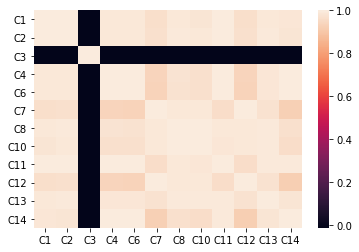

In [17]:
sns.heatmap(x_fraud[column_groups['C']].corr());

In [18]:
C_original_cols = preproc_scale(x_fraud[column_groups['C']])
pca = PCA(n_components=3, whiten=True)
C_transformed_cols = pca.fit_transform(C_original_cols)

var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(var1) # NB: 3 variables recovers 98% of variance


[89.97 98.3  99.8 ]


### D- columns

D1-D15: timedelta, such as days between previous transaction, etc.

In [19]:
D_imputed = median_imputation(x_fraud[column_groups['D']].copy(), median_impute_limit=0)
D_original = preproc_scale(D_imputed)

pca = PCA(n_components=10, whiten=True)
D_transformed = pca.fit_transform(D_original)
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(var1) 
# Quite many components are needed for good reconstruction. 
# Take only 4 columns to reconstruct 60%
D_transformed = D_transformed[:, :4]

[35.67 47.04 55.2  63.26 70.45 77.38 83.64 88.8  92.56 95.35]


### V- columns
There are 339 V-columns, that are supposedly very relevant. 
"Vesta engineered rich features, including ranking, counting, and other entity relations." All numerical. 

In [20]:
x_fraud[column_groups['V']].shape

(70093, 310)

In [21]:
V_original = median_imputation(x_fraud[column_groups['V']], median_impute_limit=0)
V_original = preproc_scale(V_original)
pca = PCA(n_components=25, whiten=True)
V_transformed = pca.fit_transform(V_original)
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(var1) 
# With 25 columns (compression of more than 90%), we recover 73% of the signal

[11.79 19.34 26.16 31.84 36.82 41.41 45.21 48.7  51.88 54.93 57.62 59.87
 61.97 63.87 65.59 67.12 68.57 69.89 71.15 72.35 73.46 74.5  75.43 76.28
 77.1 ]


### Transaction amount

In [22]:
x_fraud[column_groups['trans'][2]].describe()

count    70093.000000
mean        96.036720
std        112.044579
min          0.292000
25%         31.132000
50%         60.000000
75%        100.000000
max       1550.000000
Name: TransactionAmt, dtype: float64

In [23]:
log_trans_amount = np.log10(1 + x_fraud.loc[:, [column_groups['trans'][2]]])


In [24]:
x_fraud_processed = np.concatenate([card_cols[card_colnames_dummies].values, 
                                  dist_cols.values,
                                  C_transformed_cols,
                                  D_transformed,
                                  V_transformed,
                                  log_trans_amount], 
                                   axis=1)

In [25]:
pd.DataFrame(data=x_fraud_processed).describe()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
count,70093.000000,70093.000000,70093.000000,70093.000000,70093.000000,70093.000000,70093.000000,7.009300e+04,7.009300e+04,7.009300e+04,...,7.009300e+04,7.009300e+04,7.009300e+04,7.009300e+04,7.009300e+04,7.009300e+04,7.009300e+04,7.009300e+04,7.009300e+04,70093.000000
mean,0.020031,0.278059,0.630890,0.548257,0.451529,75.504729,0.778951,-9.731657e-18,-3.588548e-17,9.079636e-15,...,-1.891185e-15,1.053452e-15,-3.600713e-16,-1.436230e-15,-5.577152e-15,-8.312356e-15,9.453899e-15,-3.933211e-16,-4.786759e-15,1.807633
std,0.140106,0.448046,0.482567,0.497669,0.497649,272.261885,0.414956,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.391646
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.132447e-01,-9.182757e-02,-2.480779e+00,...,-1.551293e+01,-1.524153e+01,-1.478580e+01,-2.677231e+01,-2.170818e+01,-1.968678e+01,-2.248231e+01,-1.895479e+01,-2.084072e+01,0.111263
25%,0.000000,0.000000,0.000000,0.000000,0.000000,28.000000,1.000000,-1.356280e-01,-9.179979e-02,-6.072462e-02,...,-1.473967e-01,-1.108133e-01,-6.904047e-03,-6.273034e-02,-9.936761e-02,-5.892452e-02,-7.092243e-02,-1.405141e-01,-1.945342e-01,1.506938
50%,0.000000,0.000000,1.000000,1.000000,0.000000,28.000000,1.000000,-1.353688e-01,-9.179979e-02,-5.330471e-02,...,-9.613347e-02,-7.607449e-02,-6.904047e-03,-2.797601e-02,-9.936761e-02,-4.736551e-02,-7.092243e-02,-1.173976e-01,-7.105920e-02,1.785330
75%,0.000000,1.000000,1.000000,1.000000,1.000000,28.000000,1.000000,-1.344225e-01,-9.177575e-02,-4.901487e-02,...,-9.613347e-02,9.163803e-02,1.442076e-01,4.232443e-02,1.526896e-02,1.198241e-01,9.697810e-02,2.079820e-02,9.849603e-02,2.004321
max,1.000000,1.000000,1.000000,1.000000,1.000000,9103.000000,1.000000,1.305674e+01,7.047581e+01,1.433028e+01,...,2.212998e+01,2.164438e+01,3.371814e+01,3.493367e+01,2.902543e+01,2.131506e+01,2.886366e+01,2.852343e+01,2.518459e+01,3.190612


### To-do general:
- Check details of PCA (whitening, do we correctly center around the mean?, ..)
- Check what happens if only taking columns with has_id --> AUC score increases by 0.03 --> change the data!
- Try to .groupby().aggregate() the max of the score over the columns that identify a user --> does not make it better

#### To-do autoencoder
- Scaling outside of autoencoder (don't scale binary columns, for instance)
- Custom loss model ( cross-entropy loss for binary features, l2 loss for numerical features)
- Getting the middle layer (hidden representation) and do outlier scores on those

In [26]:
from keras.optimizers import Adam
adam = Adam(learning_rate=1.E-4)
clf = AutoEncoder(
    hidden_neurons=[30, 20, 30],
    hidden_activation='elu',
    output_activation='linear',
    optimizer=adam,
    epochs=8,
    batch_size=16,
    dropout_rate=0.2,
    l2_regularizer=0.0,
    validation_size=0.1,
    preprocessing=True,
    verbose=1,
    random_state=1,
    contamination=0.1,
)

In [27]:
clf.fit(x_fraud_processed)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 40)                1640      
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 40)                1640      
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1230      
_________________________________________________________________
dropout_3 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)               

AutoEncoder(batch_size=16, contamination=0.1, dropout_rate=0.2, epochs=8,
      hidden_activation='elu', hidden_neurons=[30, 20, 30],
      l2_regularizer=0.0,
      loss=<function mean_squared_error at 0x7ff549aead90>,
      optimizer=<keras.optimizers.Adam object at 0x7ff5466320f0>,
      output_activation='linear', preprocessing=True, random_state=1,
      validation_size=0.1, verbose=1)

In [47]:
y_train_scores = clf.decision_scores_  # raw outlier scores
y_train_scores = np.clip(y_train_scores, 0, 50) # for visual purposes

In [29]:
aggregate_over_uid = True
y_train_df = pd.DataFrame(columns=['score', 'uid', 'agg_score'])
y_train_df['score'] = y_train_scores

if aggregate_over_uid:
    x_fraud['D1n'] = np.floor(x_fraud.TransactionDT / (24*60*60)) - x_fraud.D1
    x_fraud['uid'] = x_fraud.card1.astype(str)+'_'+x_fraud.addr1.astype(str)+'_'+x_fraud.D1n.astype(str)
    y_train_df['uid'] = x_fraud.reset_index()['uid']
    y_train_df['agg_score'] = y_train_df.groupby('uid')['score'].transform('max')
y_train_scores = y_train_df['agg_score']

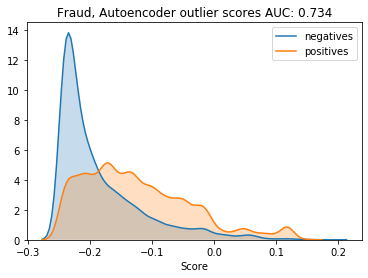

In [50]:
res = plot_outlier_scores(y_fraud.values, y_train_df['agg_score'].values, 
                          bw=0.01, title='Fraud, Autoencoder outlier scores')

In [103]:
len(y_train_scores)

70093

30/20/30 
- with all 200 K points: AUC 0.717
- with only has_id (70K): AUC 0.743
- with only has_id (70K) AND aggregated score over uid: 

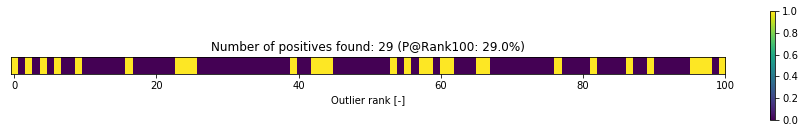

In [40]:
res = plot_top_N(y_fraud.values, y_train_scores.values, N=100)

- with all 200 K points: 18.3%
- with only has_id (70K): 18.7%
- with only has_id and aggregated scores: 17.3%


In [34]:
ifo = IsolationForest(n_estimators=100, max_samples=1024, random_state=1, contamination=0.01, behaviour='new')
ifo.fit(x_fraud_processed)
kdd_isof_scores = - ifo.decision_function(x_fraud_processed)

In [35]:
aggregate_over_uid = True
y_train_df = pd.DataFrame(columns=['score', 'uid', 'agg_score'])
y_train_df['score'] = kdd_isof_scores

if aggregate_over_uid:
    x_fraud['D1n'] = np.floor(x_fraud.TransactionDT / (24*60*60)) - x_fraud.D1
    x_fraud['uid'] = x_fraud.card1.astype(str)+'_'+x_fraud.addr1.astype(str)+'_'+x_fraud.D1n.astype(str)
    y_train_df['uid'] = x_fraud.reset_index()['uid']
    y_train_df['agg_score'] = y_train_df.groupby('uid')['score'].transform('max')
kdd_isof_scores = y_train_df['agg_score']

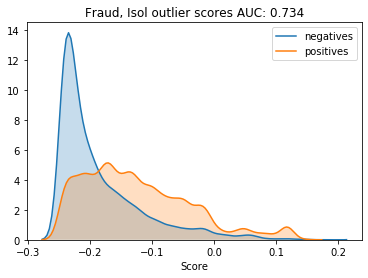

In [37]:
res = plot_outlier_scores(y_fraud.values, kdd_isof_scores.values, 
                          bw=0.01, title='Fraud, Isol outlier scores')

- with all 200 K points: AUC 0.71...
- with only has_id (70K): AUC 0.741
- with only has_id (70K) and aggregated scores: AUC 0.734


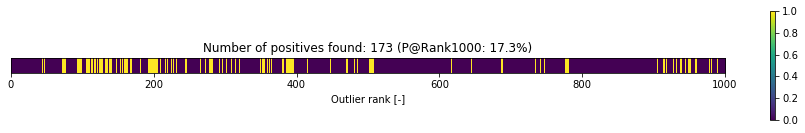

In [39]:
res = plot_top_N(y_fraud.values, kdd_isof_scores.values, N=1000)

- with all 200 K points: 18.3%
- with only has_id (70K): 18.7%
- with only has_id (70K) and aggregated scores: 17.3%
